# Assignment #3 - Reinforcement Learning

### <font color="red"> DUE: Nov 2 (Friday) 11:00 pm </font>  

<font color="blue"> Meghana Setty </font>
<br/>
<font color="blue"> 801074198 </font>

# I. Overview

The objective of the assignment is to apply reinforcement learning algorithms like SARSA/QLearning to some of the well played puzzle games like MAZE and Poker.

I have used SARSA reinforcement algorithm to learn the MAZE and Poker environment.

# II. Problems 

## A. Maze Problem (Practice)

### Description
This is a classic Maze Problem which contains lot of passages and walls. We have a start position and goal position. The user must find the path from start postion to the goal by passing through the passages. The goal can be reached from multiple paths. The optimum path is the one where we reach the goal in minimum number of steps.

### GridWorld Environment
To design our agent to find the path in the Maze, we have designed an environment,"GRIDWORLD Environment."
The **gridworld** is represented in a text file with open spaces, walls and goal location.
The agent can pass through the openspaces to find the goal position.
In the text file, the open positions are represented by **'O'**, the walls are represented by **'H'** and the Goal position by **'G'**.

The agent can move in four directions in the grid. UP,DOWN,LEFT,RIGHT. These are the actions for the grid. The actions are valid only if they are within the grid. If the agent goes out the grid we give a reward of -5.
Rewards given to the agent:
1. If the agent goes out of the grid,moves to an invalid state or hits a wall, we give a reward of -5
2. As we want to limit the number of steps the agent takes to reach the goal, we give a reward of -1 for every step it takes.
3. Whenever the agent reached the goal, we give a positive reward of 30.

### Sample Grid Environment File

Simple text file with three characters, 'O', 'H', and 'G'.
- 'O': open space
- 'H': Wall or obstacles
- 'G': Goal location 

In [86]:
import collections
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### GridWorld Class


In [87]:
# maze example

class GridWorld:
    """ Grid World environment
            there are four actions (left, right, up, and down) to move an agent
            In a grid, if it reaches a goal, it get 30 points of reward.
            If it falls in a hole or moves out of the grid world, it gets -5.
            Each step costs -1 point. 

        to test GridWorld, run the following sample codes:

            env = GridWorld('grid.txt')

            env.print_map()
            print [2,3], env.check_state([2,3])
            print [0,0], env.check_state([0,0])
            print [3,4], env.check_state([3,4])
            print [10,3], env.check_state([10,3])

            env.init([0,0])
            print env.next(1)  # right
            print env.next(3)  # down
            print env.next(0)  # left
            print env.next(2)  # up
            print env.next(2)  # up

        Parameters
        ==========
        _map        ndarray
                    string array read from a file input
        _size       1d array
                    the size of _map in ndarray
        goal_pos    tuple
                    the index for the goal location
        _actions    list
                    list of actions for 4 actions
        _s          1d array
                    current state
    """
    def __init__(self, fn):
        # read a map from a file
        self._map = self.read_map(fn)
        self._size = np.asarray(self._map.shape)
        self.goal_pos = np.where(self._map == 'G')

        # definition of actions (left, right, up, and down repectively)
        self._actions = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self._s = None

    def get_cur_state(self):
        return self._s

    def get_size(self):
        return self._size

    def read_map(self, fn):
        grid = []
        with open(fn) as f:
            for line in f:
               grid.append(list(line.strip()))
        return np.asarray(grid)

    def print_map(self):
        print( self._map )

    def check_state(self, s):
        if isinstance(s, collections.Iterable) and len(s) == 2:
            if s[0] < 0 or s[1] < 0 or\
               s[0] >= self._size[0] or s[1] >= self._size[1]:
               return 'N'
            return self._map[tuple(s)].upper()
        else:
            return 'F'  # wrong input

    def init(self, state=None):
        if state is None:
            s = [0, 0]
        else:
            s = state

        if self.check_state(s) == 'O':
            self._s = np.asarray(state)
        else:
            raise ValueError("Invalid state for init")

    def next(self, a):
        s1 = self._s + self._actions[a]
        # state transition
        curr = self.check_state(s1)
        
        if curr == 'H' or curr == 'N':
            return -5
        elif curr == 'F':
            warnings.warn("invalid state " + str(s1))
            return -5
        elif curr == 'G':
            self._s = s1
            return 30
        else:
            self._s = s1
            return -1
        
    def is_goal(self):
        return self.check_state(self._s) == 'G'
            
    def get_actions(self):
        return self._actions

In [88]:
env = GridWorld("grid.txt")
env.print_map()

[['O' 'O' 'O' 'H' 'O' 'O' 'O' 'O' 'O']
 ['O' 'O' 'O' 'H' 'O' 'O' 'H' 'O' 'O']
 ['O' 'O' 'O' 'O' 'O' 'O' 'H' 'O' 'O']
 ['O' 'O' 'O' 'O' 'H' 'H' 'H' 'O' 'O']
 ['O' 'O' 'H' 'O' 'O' 'O' 'O' 'O' 'H']
 ['O' 'O' 'H' 'O' 'O' 'O' 'G' 'O' 'O']
 ['O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O']]


In [89]:
# top-left to (0,0)
def coord_convert(s, sz):
    return [s[1], sz[0]-s[0]-1]

## B. One-Card Poker  

![](http://www.poker-vibe.com/poker/terms/case-card/Case-Card.jpg)

<font color="red"> Game Introduction and Rules: </font>
1. This is a 1-card poker game. Where each player can blindly bet from 0 (fold), 1, 2 or 3 in the first round. In the next round only the player who havent matched the max amount( from all the players) will be given a chance to bet additional amount to match or fold. 


2. Each player will be able to see his/her own card and the total pot balance and all other player's balance and their current bet on for the round i.e this is what you can call the current state of the game. <br>

    a. <font color="red"> Example1 </font>: 3 players in game i.e. player1, computer1, computer2. First round, player1        bets 3, computer1 bets 2 and computer2 bets 1. Next round only computer1 and computer2 will be given a chance          to match the bet as player1 has max bet so computer1's available actions will be (0, 1) and computer2's                available actions will be (0, 2).<br>
    
    b. After they match or fold the result will be given. <br>
    
    c. This case is applicable for player1 being the one who needs to match. <font color="red"> Example2 </font>: 3          players in game i.e player1, computer1, computer2. First round, player1 bets 1, computer1 bets 2 and                  computer2 bets 3. Next round only player1 and computer1 will have chance to bet and match or fold. <br>
       
    d. The examples described above will be 1 round each, this will continue until player1 losses all the money or            computer1 and computer2 will be out of money. <br>
    
This is a local version of the game, your final competition if you decide to participate will be hosted on server. The local version, you can add multiple computer players in the game but only single agent.

This way you can train your agent to play against 1,2,3,4 


### Description of Poker Problem
For our Poker problem, we have only two players.
1. Player(agent)
2. Computer

The goal of the agent is to win the game. The actions of the agent in the first round is to fold or bet(1,2 or 3). WHile in the second round the agent can fold or match the bet.
We are training the agent such that it analyses the card, and few other parameters to decide whether it can fold or bet the game. 

### Player Class

This contains the player information:
1. Player Name: The different players are identified by the player_name
2. card : The value of the card which is generated randomly for every game
3. total_balance: The balance remaining with the player
4. current_bet: The bet value currently made in the deal.
5. is_computer: To determine if the player is the agent or the computer
6. is_active: This is true when the player still have a balance/can play the game
7. number_of_turn: This increases as the round increases
8. match_bet: This is used to determine if the player matched the bet with the other player/computer

### Poker Class

1. The Poker class intially takes the number of players in the game.
2. We add the players by giving the player name using add_player method. The add_player returns exception when the number of players exceeds the players that are being added.
3. We start a deal() - which return True if there are more than one player playing the game or return False otherwise. If draws the card during the first deal for each player
4. The get_valid_actions() get the valid actions for the players(for round 1, he can choose anyone of the 4 actions whereas in round 2, he can either match the bet or fold)
5. We then choose one action from the above valid_actions and use player_play() function to play the game. The player_play() function include the computer_play() also which allows the computer to play the game.
6. We then use the function check_and_return_reward function to check which player won and return the reward if the game is won by the player. If the game is a draw, we share the total_pot_balance equally to the players.


## One-Card Poker Environment

In [6]:
import copy
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
def draw_card():
    return deck[np.random.randint(0, 13)]

In [7]:
class Player():
    """
        
        Player class to create a player object.
        eg: player = Player("player1", start_balance = 10, is_computer = 0)
        Above declaration will be for your agent. Only one non-computer
        player allowed in the local poker instance.
        However, you can create as many as you want computer_players 
        (test for 3 players but you can try more) i.e
        computer = Player("computer", start_balance = 10, is_computer = 1).
        All the player names should be unique or else you will get error.
        
    """
    def __init__(self, player_name, start_balance = 10, is_computer = 0):
        self.player_name = player_name
        self.card = None
        self.total_balance = start_balance
        self.current_bet = 0
        self.is_computer = is_computer
        self.is_active = 0
        self.number_of_turn = 0
        self.match_bet = False
    
    def get_info(self):
        print("Player name: {}".format(self.player_name))
        print("Player card: {}".format(self.card))
        print("Player total_balance: {}".format(self.total_balance))
        print("Player is_active: {}".format(self.is_active))
        

In [8]:
class Poker():
    """
        Poker class will be the environment. 
        Important functions for users:
        1. Init Poker class i.e poker = Poker(number_of_player = 2)
           <Please dont add more than the number you declare here)
        2. add_player(player1) - adds player1 object to the game.
        3. get_current_state - gets the current state of the env
           {'other_stats': [[9, 1] ,[9, 1]], 'total_pot_balance': 2, 'player_stats': [6, 9, 1]}
           other_stats will contain the opponent information's balance and their current bet
           total_pot_balance will have total bet played by all players
           player_stats will contain player_card, player total balance, player current bet
        4. get_valid_actions -  returns the valid action available for the player
           based on balance and which round the player is in. You should take actions
           based on the return value.
           
    
    """
    def __init__(self, number_of_player = 2):
        self.all_players = []
        self.total_players = number_of_player
        self.total_pot_balance = 0
        self.player = None
        self.actions = [0, 1, 2, 3]
        self.number_of_turn = 0
        self.max_bet = 0
        
    def add_player(self, player_class):
        if player_class not in self.all_players and self.total_players > 0:
            self.all_players.append(player_class)
            self.total_players -= 1
            if player_class.is_computer == 0:
                if self.player == None:
                    self.player = player_class
                else:
                    raise Exception("Will override current player ! Only one non-computer player allowed !")
        else:
            raise Exception("Maximum number of player allowed: {}. You can increase the player count while initializing the environment".format(len(self.all_players)))
    
    def check_and_remove_players(self):
        player_remove, game_end = [], False
        for _player in self.all_players:
            if _player.total_balance <= 1:
                player_remove.append(_player)
        if len(player_remove) > 0:
            if self.player not in player_remove:
                for player in player_remove:
                    #print("Removing player: {} due to insufficient funds !!".format(player.player_name))
                    self.all_players.remove(player)                    
            else:
                #print("Player doesnt have balance !")
                game_end = True
        return game_end        
                
    def deal(self):
        reset_game = False
        self.total_pot_balance = 0
        self.number_of_turn = 0
        
        if self.check_and_remove_players():
            reset_game = True
        else:
            if len(self.all_players) == 1:
                reset_game = True
            else:
                for _player in self.all_players:
                    if _player.total_balance > 1:
                        _player.card = draw_card()
                        _player.total_balance -= 1
                        _player.current_bet = 1
                        _player.is_active = 1
                        _player.number_of_turn = 0
                        _player.match_bet = False
                        self.total_pot_balance += 1
                        self.max_bet = 0
                    else:
                        #print("{} can no longer play the game !".format(_player.player_name))
                        reset_game = True        
        return reset_game
        
    def get_current_state(self):
        current_state_dict = {}
        current_state_dict['other_stats'] = [[_player.total_balance,_player.current_bet] for _player in self.all_players if _player != self.player]
        current_state_dict['total_pot_balance'] = self.total_pot_balance
        current_state_dict['player_stats'] = [self.player.card, self.player.total_balance, self.player.current_bet]
        return current_state_dict
    
    def get_valid_actions(self, player_name):
        #print('player name ',player_name)
        #for players in self.all_players:
         #   print('all players ',players.player_name)
        list_player = [_player for _player in self.all_players if _player.player_name == player_name]
        #print("length of list_player ",len(list_player)," ",list_player)
        if len(list_player) == 1:
            player = list_player[0] 
            if player.number_of_turn == 0:
                if player.total_balance > 3:
                    actions =  [0, 1, 2, 3]
                elif player.total_balance <= 3:
                    if player.total_balance <= 1:
                        actions = [0]
                    elif player.total_balance > 1 and player.total_balance <= 2:
                        actions =  [0, 1]
                    else:
                        actions = [0, 1, 2]
            else:
                possible_max_bet = player.total_balance - (self.max_bet - (player.current_bet - 1))
                if possible_max_bet >= 2:
                    actions = [0, self.max_bet - (player.current_bet - 1)]
                else:
                    actions = [0]                        
            return actions
        else:
            raise Exception("Invalid player name! Use the player name defined while initialzing the environment")
    
    def print_actions(self, player, action):
        if action == 0:
            #print("{} folds".format(player))
            pass
        else:
            #print("{} plays {}.".format(player, action))
            pass
        
    def computer_play(self):
        list_player = [_player for _player in self.all_players if _player.player_name != self.player.player_name and _player.is_active == 1 and _player.match_bet == False]
        for player in list_player:
            actions_available = self.get_valid_actions(player.player_name)    
            #print("Available actions for: {} are {}".format(player.player_name, actions_available))
            action_taken = actions_available[np.random.randint(len(actions_available))]
            self.print_actions(player.player_name, action_taken)
            if self.max_bet == 0 and action_taken != 0 or self.max_bet < action_taken:
                self.max_bet = action_taken
            self.take_action(player.player_name, action_taken)
    
    def get_player(self, player_name):
        return_player = [player for player in self.all_players if player.player_name == player_name]
        if len(return_player) != 1:
            #print("Invalid Player")
            return None
        else:
            return return_player[0]
        
    def take_action(self, player_name, action_taken):
        player = self.get_player(player_name)
        player.number_of_turn += 1
        if action_taken != 0:
            player.total_balance -= action_taken
            player.current_bet += action_taken
            self.total_pot_balance += action_taken
            player.is_active = 1
        else:
            player.is_active = 0
            
    def check_game(self):
        game_over = True
        if np.sum([_player.is_active for _player in self.all_players if _player != self.player]) > 0:
            game_over = False
        return game_over
     
    def return_winner(self, players):
        max_card = np.max([_player.card for _player in players])
        return [_player for _player in players if _player.card == max_card]
            

    def settle_balance(self, winner):
        reward = 0
        if winner == "draw":
            active_player = [_player for _player in self.all_players if _player.is_active]
            if len(active_player) == 0:
                #print("Active player cards: {}".format([(_player.player_name, _player.card) for _player in self.all_players]))
                winning_players = self.all_players
            else:
                #print("Active player cards: {}".format([(_player.player_name, _player.card) for _player in self.all_players if _player.is_active]))
                winning_players = self.return_winner(active_player)
                
            per_player_share = self.total_pot_balance / len(winning_players)
            for _player in winning_players:
                _player.total_balance += per_player_share
            if self.player in winning_players:
                reward = per_player_share
            else:
                reward = -self.player.current_bet
            
                
        if winner == "player":
            self.player.total_balance += self.total_pot_balance
            reward = self.total_pot_balance
            winning_players = [self.player]
            
        if winner == "computer":
            active_player = [_player for _player in self.all_players if _player != self.player and _player.is_active]
            winning_players = self.return_winner(active_player)
            per_player_share = self.total_pot_balance / len(winning_players)
            for _player in winning_players:
                _player.total_balance += per_player_share
            reward = -self.player.current_bet
            
        #print("Printing winning players: {}".format(' '.join([player.player_name for player in winning_players])))
        #print("Reward : {}".format(reward))
        return reward
        
    def check_game_return_reward(self, round_num):
        #print("Check results for Round Number: {}".format(round_num))
        if self.check_game() and self.player.is_active == 0:
            #print("Computer folds, Player folds !")
            game_over = True
            winner = "draw"
            reward = 0
            return game_over, reward, winner 
        
        elif self.check_game() and self.player.is_active:
            #print("Computer folds, Player active ! ",self.total_pot_balance)
            game_over = True
            reward = self.total_pot_balance
            winner = "player"
            return game_over, reward, winner 
        
        elif not self.check_game() and self.player.is_active == 0:
            #print("Computer active, Player folds ! ",-self.player.current_bet)
            game_over = True
            reward = -self.player.current_bet
            winner = "computer"
            return game_over, reward, winner 

        if round_num == 1:
            #print("Computer active, Player active ! ")
            game_over = False
            reward = 0
            winner = "draw"
            return game_over, reward, winner 
        
        else:
            #print("Computer active, Player active in Round 2 ! End game now !")
            game_over = True
            active_players = [player for player in self.all_players if player.is_active]
            #print("Active player cards: {}".format([(_player.player_name, _player.card) for _player in active_players]))
            winning_players = self.return_winner(active_players)
            if self.player in winning_players:
                if len(winning_players) > 1:
                    reward = self.total_pot_balance / len(winning_players)
                    winner = "draw"
                else:
                    reward = self.total_pot_balance
                    winner = "player"
            else:
                reward = -self.player.current_bet
                winner = "computer"
            #print("THe reward is ",reward)
            return game_over, reward, winner 
            

    
    def update_match(self):
        for player in [player for player in self.all_players if player.current_bet - 1 == self.max_bet]:
            player.match_bet = True
    
    def check_computer_status(self):
        computer_play = False
        if len([player for player in self.all_players if player.is_computer == 1 and player.match_bet == False and player.is_active == 1]) > 0:
            computer_play = True
        return computer_play
    
    def player_play(self, player_name, action_taken):
        game_over = False
        reward = 0  
        winner = None
        self.number_of_turn += 1
        
        if self.number_of_turn == 1:
            if self.max_bet == 0 and action_taken != 0 or self.max_bet < action_taken:
                self.max_bet = action_taken
            self.print_actions(player_name, action_taken)
            self.computer_play()
            self.take_action(player_name, action_taken)
            self.update_match()
            if self.player.is_active:
                if self.player.match_bet and not self.check_computer_status():
                    #print("Player and Computer both Bet Max and match !")
                    _, reward, winner = self.check_game_return_reward(round_num=1)
                    game_over = True
            else:
                if self.check_computer_status():
                    #print("Player folds, computer players are active, they will play among themselves !")
                    self.computer_play()
                game_over, reward, winner = self.check_game_return_reward(round_num=1)
                
            if game_over:
                #print("Winner: {}".format(winner))
                new_reward = self.settle_balance(winner)
                if winner == "draw":
                    reward = new_reward
            else:
                if self.player.match_bet and self.check_computer_status():
                    #print("Player Bet Max, computer will match now !")
                    self.computer_play()
                    game_over, reward, winner = self.check_game_return_reward(round_num=2)
                    #print("Winner: {}".format(winner))
                    new_reward = self.settle_balance(winner)
                    if winner == "draw":
                        reward = new_reward
                    
            return self.get_current_state(), reward, game_over
        
        if self.number_of_turn == 2:
            self.print_actions(player_name, action_taken)
            self.take_action(player_name, action_taken)
            if self.check_computer_status():
                self.computer_play()
            game_over = True
            _, reward, winner = self.check_game_return_reward(round_num=2)
            #print("Winner: {}".format(winner))
            new_reward = self.settle_balance(winner)
            if winner == "draw":
                reward = new_reward
        
        return self.get_current_state(), reward, game_over
    
    
        

### Example Run with Random Players

In [9]:
poker = Poker(number_of_player=2)
player1 = Player("prajval", start_balance = 10, is_computer =  0)
computer1 = Player("computer1", start_balance = 10, is_computer = 1)
#computer2 = Player("computer2", start_balance = 10, is_computer = 1)
poker.add_player(player1)
poker.add_player(computer1)
#poker.add_player(computer2)
while not poker.deal():
    print("-"*50)
    print("Deal Start!")
    print("Start State: {}".format(poker.get_current_state()))
    actions = poker.get_valid_actions("prajval")
    print("Available actions for: prajval are {}".format(actions))
    action_taken = actions[np.random.randint(len(actions))]
    result = poker.player_play("prajval", action_taken)
    while not result[-1]:
        actions = poker.get_valid_actions("prajval")
        print("Available actions for: prajval are {}".format(actions))
        action_taken = actions[np.random.randint(len(actions))]
        result = poker.player_play("prajval", action_taken)
    print("Final Result: {}".format(result))
    print("*"*50)
    

--------------------------------------------------
Deal Start!
Start State: {'other_stats': [[9, 1]], 'total_pot_balance': 2, 'player_stats': [3, 9, 1]}
Available actions for: prajval are [0, 1, 2, 3]
Final Result: ({'other_stats': [[9, 1]], 'total_pot_balance': 4, 'player_stats': [3, 11, 3]}, 4, True)
**************************************************
--------------------------------------------------
Deal Start!
Start State: {'other_stats': [[8, 1]], 'total_pot_balance': 2, 'player_stats': [1, 10, 1]}
Available actions for: prajval are [0, 1, 2, 3]
Final Result: ({'other_stats': [[12.0, 3]], 'total_pot_balance': 6, 'player_stats': [1, 8, 3]}, -3, True)
**************************************************
--------------------------------------------------
Deal Start!
Start State: {'other_stats': [[11.0, 1]], 'total_pot_balance': 2, 'player_stats': [12, 7, 1]}
Available actions for: prajval are [0, 1, 2, 3]
Final Result: ({'other_stats': [[12.0, 1]], 'total_pot_balance': 2, 'player_stats

In [10]:
poker.deal()

True

In [11]:
poker.get_current_state()

{'other_stats': [[19.0, 4]],
 'total_pot_balance': 0,
 'player_stats': [4, 1.0, 3]}

In [12]:
poker.get_valid_actions("prajval")

[0]

In [13]:
poker.player_play("prajval", 1)

({'other_stats': [[20.0, 4]],
  'total_pot_balance': 1,
  'player_stats': [4, 0.0, 4]},
 -4,
 True)

# III. Methods

- Decide your TD learning approach: SARSA or Q-learning? 
- Describe your approach and the reason why you select it.
- Finish epsilon_greedy function and other TODOs. Explain it.
- Explain your codes.

### Temporal difference Learning

*Temporal difference (TD) learning* considers that the agent knows only the partial information of the MDP. 
With only current and next state transition and without any model transition probability, TD lets the agent explore the environment to examine the random policy. 
With an estiate of the value function $V(s)$, $\hat{V}(s)$, 

   $$ 
        \begin{align}
        V(s_t) &= R_{t+1} + \gamma V(s_{t+1}) \\
        V(s_t) &\sim R_{t+1} + \gamma \hat{V}(s_{t+1}) \\
        \Rightarrow \quad \delta_t &= R_{t+1} + \gamma \hat{V}(s_{t+1}) - V(s_t).
        \end{align}
    $$
    
Here, $\delta$ represents the *temporal diffrence error*. 
We can use this error as a gradient to update the value estimation.

$$
    \begin{align}
        V(s_t) &\leftarrow R_{t+1} + \alpha \delta_t \\
        V(s_t) &\leftarrow R_{t+1} + \alpha (R_{t+1} + \gamma \hat{V}(s_{t+1}) - V(s_t))
    \end{align}
$$

we have defined Q function above to evaluate the state and action altogether.
Updating the Q values with TD learning is similar to previous update with two different considerations. 

#### SARSA

First, we update the Q with assumption that we follow a certain behavior policy. Thus, we call this as *on-policy control*, or **SARSA**. 

$$
    Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha ( R_{t+1} + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t)) 
$$

#### Q-learning

Without making assumption of behavior policy, we can explore other possible policies to update the Q. We call this as *off-policy control*, or **Q-learning**. 


$$
    Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha ( R_{t+1} + \gamma \max_a Q(s_{t+1}, a) - Q(s_t, a_t)) 
$$

## RLAgent for Maze

For designing the RLAgent for the Maze problem, the TD learning algorithm I have taken is SARSA.

I have choosen SARSA over QLearning because of following reason:

    -- SARSA takes into account the control policy by which the agent is moving, and incorporates that into its update of action values, where Q-learning simply assumes that an optimal policy is being followed.
    
   For Example, In SARSA, the agent starts in state 1, performs action 1, and gets a reward (reward 1). Now, it’s in state 2 and performs another action (action 2) and gets the reward from this state (reward 2) before it goes back and updates the value of action 1 performed in state 1. In contrast, in Q-learning the agent starts in state 1, performs action 1 and gets a reward (reward 1), and then looks and sees what the maximum possible reward for an action is in state 2, and uses that to update the action value of performing action 1 in state 1. 
   
   So the difference is in the way the future reward is found. In Q-learning it’s simply the highest possible action that can be taken from state 2, and in SARSA it’s the value of the actual action that was taken.



#### Implementation Details

__init__ : we initialize the GRIDWorld envinroment and initialize the Q table with Zeroes

Epsilon_greed/greedy method: We generate the actions(up,down,left,right) either randomly or based on Q table by taking into consideration of the epsilon value. The higher the epsilon, the less chance of randomly choosing the action.

**TRAIN**
1. We take the start state and try to explore all the possible ways to reach the goal state.
2. We iterate the max_iters times.
3. As we are using SARSA, we are doing the following:
    1. Get the state and perform the action and make a note of the reward
    2. Move to the next state, find the suitable action a1.
    3. Based on the action(current and next action), we modify the Q table.
    4. This process keeps repeating till the Goal is reached
Note: The less the epsilon value, the more the chance to explore the GRIDWorld

**TEST**
1. For the test, we give a start state, and only use greedy() method as we want to trace the path to the goal position by Q table values and not randomly.


### Answer to the question in the code: 

When the GOAL is reached, why is the value zero(0)?

    When ever the Goal is reached, our agent needs to stop at that point and need not explore any further. The Q table values are there to find weight/probability of the next possible state which is not needed when the goal is reached. So the values of the Goal Q cell is zero

In [14]:
class RLAgent: 
    """
        Reinforcement Learning Agent Model for training/testing
        with Tabular function approximation
        
    """
    
    def __init__(self, env):
        self.env = env
        self.size = env.get_size()
        self.n_a = len(env.get_actions())
        # self.Q table including the surrounding border
        self.Q = np.zeros((self.size[0], self.size[1], self.n_a))
        self.Q[...] = 0
        self.Q[self.env._map == 'H'] = -np.inf
        
    def epsilon_greed(self, epsilon, s):
        if np.random.rand() < epsilon:
            return np.random.randint(self.n_a)
        else:
            return self.greedy(s)
            
    def greedy(self,s):
            return np.argmax(self.Q[s[0],s[1]])
    
    def train(self, start, **params):
        # parameters
        gamma = params.pop('gamma', 0.99)
        alpha = params.pop('alpha', 0.1)
        epsilon= params.pop('epsilon', 0.1)
        maxiter= params.pop('maxiter', 1000) 
        maxstep= params.pop('maxstep', 1000)
        
        # init self.Q matrix
        #self.Q[...] = 0
        #self.Q[self.env._map == 'H'] = -np.inf
        #print("Q ",self.Q)
        # online train
        # rewards and step trace
        rtrace = []
        steps = []
        for j in range(maxiter):

            self.env.init(start)
            s = self.env.get_cur_state()
            # selection an action
            a = self.epsilon_greed(epsilon, s)

            rewards = []
            trace = np.array(coord_convert(s, self.size))
            
            # run simulation for max number of steps 
            for step in range(maxstep):
                # move
                r = self.env.next(a)
                s1 = self.env.get_cur_state()
                a1 = self.epsilon_greed(epsilon, s1)

                rewards.append(r)
                trace = np.vstack((trace, coord_convert(s1, self.size)))
                # TODO: FINISH SARSA/Q-learning Rule here
                # update self.Q table using SARSA
                #print("size ",s," ",s1," ",a," ",a1)
                
                self.Q[s[0],s[1], a] += alpha * (r + gamma * self.Q[s1[0],s1[1], a1] - self.Q[s[0],s[1],a])
                if self.env.is_goal(): # reached the goal
                    # TODO: Why is this zero? Describe this in your code explanation.
                    self.Q[s1[0], s1[1], a1] = 0
                    break

                s = s1
                a = a1

            rtrace.append(np.sum(rewards))
            steps.append(step+1)
        return rtrace, steps, trace # last trace of trajectory

    def test(self, start, maxstep=1000):
        # TODO: Add your test routine that exmines learned policy
        #      Using the learned policy, generate the trajectory of 
        self.env.init(start)
        s = self.env.get_cur_state()
        a = self.greedy(s)
        trace = np.array(coord_convert(s,self.size))
        
        for step in range(maxstep):
            r = self.env.next(a)
            s1 = self.env.get_cur_state()
            a1 = self.greedy(s1)
            trace = np.vstack((trace,coord_convert(s1,self.size)))
            
            if self.env.is_goal():
                    break
            s = s1
            a = a1
            
        return trace            

## RLAgent for One-Card Poker

# IV - Results

- Describe the choice of your parameters for $\gamma$, $\alpha$, and $\epsilon$. 
  - Run experiments to find good parameters
  - Show the experimental outputs to show the process of your selection
- Visualize the results and explain outputs (even from mine.)
  - Run the codes and tell me what you observe
  - Add more visualizations to enrich your explanation.

### Utility functions for Plotting

- finish the TODOs here for plotting

In [15]:
### Plotting tools 

def plot_trace(agent, start, trace, title="test trajectory"):
    plt.plot(trace[:, 0], trace[:, 1], "ko-")
    plt.text(env.goal_pos[1], agent.size[0]-env.goal_pos[0]-1, 'G')
    plt.text(start[1], agent.size[0]-start[0]-1, 'S')
    plt.xlim([0, agent.size[1]])
    plt.ylim([0, agent.size[0]])
    

def plot_train(agent, rtrace, steps, trace, start):

    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(221)
    # TODO: plot rewards 
    plt.plot(rtrace)
    plt.ylabel("sum of rewards")

    ax1 = fig.add_subplot(222)
    # TODO: plot steps
    plt.plot(steps)
    plt.ylabel("# steps")

    # contour plot for agent.Q
    ax2 = fig.add_subplot(223)
    xs = range(agent.size[1])
    ys = range(agent.size[0])
    maxQ = np.max(agent.Q, axis=2)
    h_b = (maxQ==-np.inf)
    maxQ[h_b] = 0
    maxQ[h_b] = np.min(maxQ) - 100
    cs = plt.contourf(xs, ys[::-1], maxQ)
    plt.colorbar(cs)
    plt.text(env.goal_pos[1], agent.size[0]-env.goal_pos[0]-1, 'G')
    plt.text(start[1], agent.size[0]-start[0]-1, 'S')
    plt.ylabel("max agent.Q")

    # plot traces
    ax3 = fig.add_subplot(224)
    plot_trace(agent, start, trace, "trace of the last episode")

    plt.plot()

### Training and Testing with GridWorld

### When gamma=0.99 alpha=0.1 epsilon=0.9

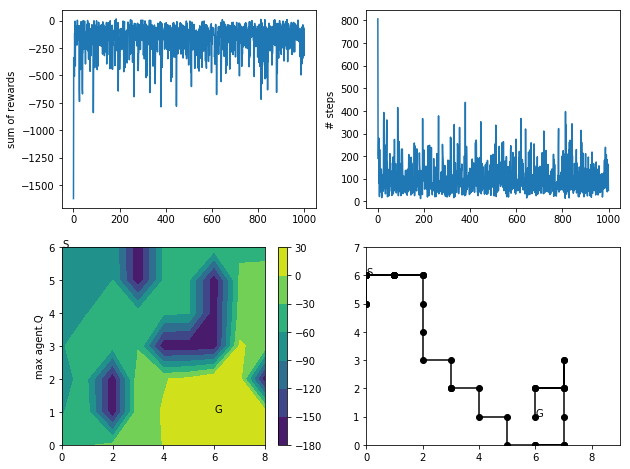

In [40]:
agent = RLAgent(env)
start = [0,0]
rtrace, steps, trace = agent.train(start, 
                                   gamma=0.99, 
                                   alpha=0.1, 
                                   epsilon=0.9, 
                                   maxiter=1000, 
                                   maxstep=1000)
plot_train(agent, rtrace, steps, trace, start)

### Results:
1. Here I have set the value of the epsilon to 0.9, which means it mostly depends on the Q value and doesnot explore the GRID very much.
2. Becasue of this, the number of steps taken is very random and doesnot keep decreasing as the training iterations increases.
3. I feel, for the training, the value of alpha should be low ~0.1

### When gamma=0.99 alpha=0.9 epsilon=0.1

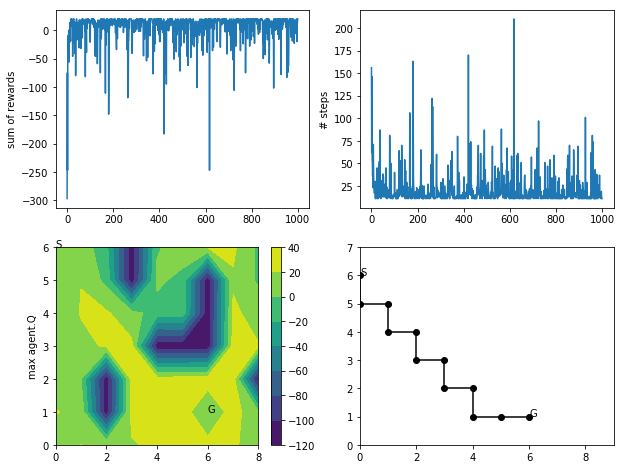

In [41]:
agent = RLAgent(env)
start = [0,0]
rtrace, steps, trace = agent.train(start, 
                                   gamma=0.99, 
                                   alpha=0.9, 
                                   epsilon=0.1, 
                                   maxiter=1000, 
                                   maxstep=1000)
plot_train(agent, rtrace, steps, trace, start)

### Results:
1. Here I have set the value of the alpha to 0.9, which means the learning rate is very high and there is a possibility for it to diverge.
2. The grid world is explored, but the number of steps it reaches the goal and the optimum path is not considered much.
2. Becasue of this, the number of steps taken is very random and doesnot keep decreasing as the training iterations increases.
3. I feel, for the training, the value of alpha can be in middle ~0.5

### When gamma=0.1 alpha=0.1 epsilon=0.9

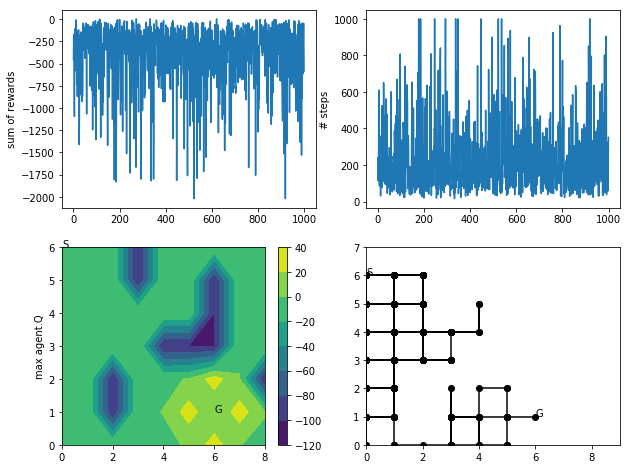

In [42]:
agent = RLAgent(env)
start = [0,0]
rtrace, steps, trace = agent.train(start, 
                                   gamma=0.1, 
                                   alpha=0.1, 
                                   epsilon=0.9, 
                                   maxiter=1000, 
                                   maxstep=1000)
plot_train(agent, rtrace, steps, trace, start)

### Results:
1. From the graphs above, we can easily say, having a lower value of gamma is very bad.
2. Gamma is the discounting factor, which means, it actually is the holder for saying "how much you care about the reward". The higher values of gamma means, we care more about the gamma.
3. Unless in very rare cases, we always care about the reward. So gamma should be high

### When gamma=0.99 alpha=0.5 epsilon=0.1

In [45]:
agent = RLAgent(env)
start = [0,0]
rtrace, steps, trace = agent.train(start, 
                                   gamma=0.99, 
                                   alpha=0.5, 
                                   epsilon=0.1, 
                                   maxiter=1000, 
                                   maxstep=1000)

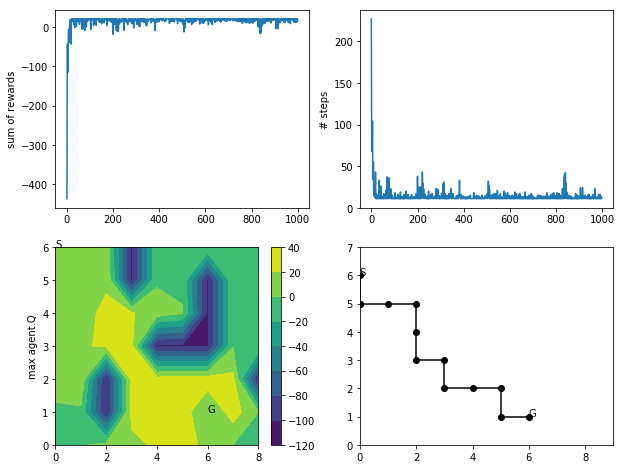

In [46]:
plot_train(agent, rtrace, steps, trace, start)


### Results:
1. With the above values, we can have a good exploration of the grid and the number of steps keeps decreasing as the agent keeps learning about the GRIDWorld.

### Selected Parameters:

gamma=0.99

alpha=0.5 

epsilon=0.1

### Results:

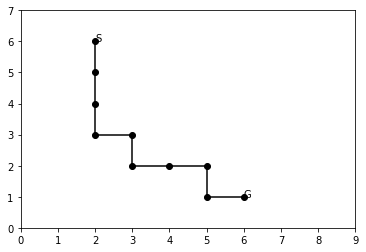

In [47]:
test_start = [0,2]
test_trace = agent.test(test_start)
plot_trace(agent, test_start, test_trace)

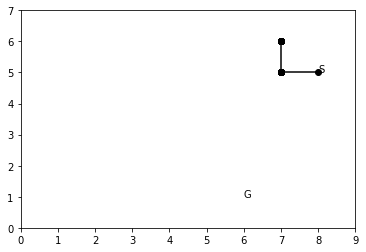

In [48]:
test_start = [1,8]
test_trace = agent.test(test_start)
plot_trace(agent, test_start, test_trace)

### REASON
1. Here the goal is not reached, because that part of the grid is not explored at all. For this to work, we need to give different start states so that the grid can reach the goal (if reached, try to reach in a optimal path).

## RLAgent for Poker

Same as Maze, For designing the RLAgent for the Poker problem, the TD learning algorithm I have taken is SARSA.

I have choosen SARSA over QLearning because of following reason:

    -- SARSA takes into account the control policy by which the agent is moving, and incorporates that into its update of action values, where Q-learning simply assumes that an optimal policy is being followed.
    
   For Example, In SARSA, the agent starts in state 1, performs action 1, and gets a reward (reward 1). Now, it’s in state 2 and performs another action (action 2) and gets the reward from this state (reward 2) before it goes back and updates the value of action 1 performed in state 1. In contrast, in Q-learning the agent starts in state 1, performs action 1 and gets a reward (reward 1), and then looks and sees what the maximum possible reward for an action is in state 2, and uses that to update the action value of performing action 1 in state 1. 
   
   So the difference is in the way the future reward is found. In Q-learning it’s simply the highest possible action that can be taken from state 2, and in SARSA it’s the value of the actual action that was taken.


### Implementation Details

#### StatePoker class:
1. This class consists of details of the player at a particular round.
    1. Value of the card: This can be from 1-13 values
    2. Total Pot Balance: This ranges from 2- 8. Because initially the player bet 1 each. And there are max of 2 rounds and if both the players bet 3(which is the max), we have 2+3+3 = 8
    3. Own Balance and Other Player Balance - This can range from 0-20(20 because, the player can win even the other players points )
    4. Others bet: THis is the bet per deal which can be (1+3 = 4)
    5. Round: which round of the deal the player is in
    6. Own Bet:  THis is the bet per deal which can be (1+3 = 4)
    
#### RLAgentPoker
__init__ : we are initializing the size of the Q table, Qtable and the number of actions the player can take(0-4)(Fold,1,2,3)

epsilon_greed/greed: We are taking into account the valid_actions by get_valid_actions method and then choosing one from them either randomly or Q table(based on epsilon value)

**TRAIN**

1. We iterate the max_iters times.
2. For every iteration, We create a poker game, and add players
3. While the deal is on(till one of the player looses all the money/have one which is not worthy to play), we do the following:
    1. Get the state of the poker usng get_curr_state, and update the value in StatePoker class.
    2. Get the valid actions and perform a action using epsilong_greed method and play.
    3. We make note of the reward
    4. Move to the next state, find the suitable action a1 using epsilong_greed method.
    5. Based on the action(current and next action), we modify the Q table.
    6. We play the action
    7. This process keeps repeating till the game is reset.

**TEST**
1. For the test, we create a poker game and only use greedy() method try to win the game.


In [54]:
class StatePoker:
    """
    This contains the state of the Poker
    The state consists of following things:
            1. Value of the card - 1-13
            2. Total Pot Balance - 2-8
            3. Own Balance - 0 - 20
            4. Others bet - 0 - 4
            5. Other player balance - 0 - 20
            6. Which round - 0 -1 
            7. own bet - 0 - 4
    """
    def __init__(self,valueofcard, totPotBlnc, ownBlnc, othBet, othPlyrBal, roundNo,ownBet):
        self.valueOfCard = valueofcard
        self.totPotBlnc = totPotBlnc
        self.ownBlnc = ownBlnc
        self.othBet = othBet
        self.othPlyrBal = othPlyrBal
        self.roundNo = roundNo
        self.ownBet = ownBet

        
class RLAgentPoker:
    """
        The actions:
            0 - 3
    """
    def __init__(self):
        self.pokerenv = None
        self.size = [14,9,21,5,21,3,5]
        self.n_actions = 4
        self.Q = np.zeros((self.size[0],self.size[1],self.size[2],self.size[3],self.size[4],self.size[5],self.size[6],self.n_actions))
        
    def epsilon_greed(self,epsilon,s,valid_actions):
        if np.random.rand() < epsilon:
            #print('valid options: ',valid_actions)
            return np.random.choice(valid_actions)
        else:
            return self.greedy(s,valid_actions)
    
    def greedy(self,s,valid_actions):
        greedy_action_values = self.Q[s.valueOfCard,s.totPotBlnc,int(s.ownBlnc),s.othBet,int(s.othPlyrBal),s.roundNo,s.ownBet]
        #print("valid actions ",valid_actions)
        #print("Q value is ",greedy_action_values)
        valid_action_Q_values = []
        for i in valid_actions:
            valid_action_Q_values.append(greedy_action_values[i])
        #print('greedy valid options: ',valid_action_Q_values)
        return np.argmax(valid_action_Q_values)
    
    def train(self,**params):
        gamma = params.pop('gamma', 0.99)
        alpha = params.pop('alpha', 0.1)
        epsilon= params.pop('epsilon', 0.1)
        maxiter= params.pop('maxiter', 1000) 
        
        # init self.Q matrix
        self.Q[...] = np.random.rand(*(self.Q.shape))
        self.Q[:,:,0:2,:,:,:,:] = -np.inf
        
        rtrace = []
        
        for j in range(maxiter):
            self.pokerenv = Poker(number_of_player=2)
            player1 = Player("Meghana", start_balance = 10, is_computer =  0)
            computer1 = Player("computer1", start_balance = 10, is_computer = 1)
            self.pokerenv.add_player(player1)
            self.pokerenv.add_player(computer1)
            #print("Episode ",j)
            r = 0
            while not self.pokerenv.deal():
                #print("Deal Start!")
                state = self.pokerenv.get_current_state()
                #print("state ",state)
                valueofcard = state['player_stats'][0]
                totPotBlnc = state['total_pot_balance']
                ownBlnc = state['player_stats'][1]
                othBet = state['other_stats'][0][1]
                othPlyrBal = state['other_stats'][0][0]
                roundNo = 0
                ownBet = state['player_stats'][2]
                s = StatePoker(valueofcard,totPotBlnc,ownBlnc, othBet, othPlyrBal, roundNo,ownBet)
                a = self.epsilon_greed(epsilon,s,self.pokerenv.get_valid_actions("Meghana"))
                result = self.pokerenv.player_play("Meghana", a)
                r = result[-2]
                #print("Reward ",r)
                while not result[-1]:
                    #print("enter into inner while")
                    state = self.pokerenv.get_current_state()
                    #print("state ",state)
                    valueofcard = state['player_stats'][0]
                    totPotBlnc = state['total_pot_balance']
                    ownBlnc = state['player_stats'][1]
                    othBet = state['other_stats'][0][1]
                    othPlyrBal = state['other_stats'][0][0]
                    roundNo = 1
                    ownBet = state['player_stats'][2]
                    s1 = StatePoker(valueofcard,totPotBlnc,ownBlnc, othBet, othPlyrBal, roundNo,ownBet)
                    #print("valueofcard ",s.valueOfCard, " totPotBlnc ",s.totPotBlnc," ownBlnc ",s.ownBlnc," othBet ",s.othBet," othPlyrBal ",s.othPlyrBal," roundNo ",s.roundNo," ownBet ",s.ownBet," action ",a)
                    #print("valueofcard ",s1.valueOfCard, " totPotBlnc ",s1.totPotBlnc," ownBlnc ",s1.ownBlnc," othBet ",s1.othBet," othPlyrBal ",s1.othPlyrBal," roundNo ",s1.roundNo," ownBet ",s1.ownBet," action ",a)
                    a1 = self.epsilon_greed(epsilon, s1,self.pokerenv.get_valid_actions("Meghana"))
                    #print("a1 ",a1)
                    #print("shape of Q ",self.Q.shape)
                    #print("Q values ",self.Q[s.valueOfCard,s.totPotBlnc,int(s.ownBlnc),s.othBet,int(s.othPlyrBal),s.roundNo,s.ownBet, a])
                    #print("Q value for s1 ",self.Q[s1.valueOfCard,s1.totPotBlnc,int(s1.ownBlnc),s1.othBet,int(s1.othPlyrBal),s1.roundNo,s1.ownBet, a1])
                    
                    #SARSA
                    #print("valueofcard ",s.valueOfCard, " totPotBlnc ",s.totPotBlnc," ownBlnc ",s.ownBlnc," othBet ",s.othBet," othPlyrBal ",s.othPlyrBal," roundNo ",s.roundNo," ownBet ",s.ownBet," action ",a," action2 ",a1)
                    #print("valueofcard ",s1.valueOfCard, " totPotBlnc ",s1.totPotBlnc," ownBlnc ",s1.ownBlnc," othBet ",s1.othBet," othPlyrBal ",s1.othPlyrBal," roundNo ",s1.roundNo," ownBet ",s1.ownBet," action ",a," action2 ",a1)
                    self.Q[s.valueOfCard,s.totPotBlnc,int(s.ownBlnc),s.othBet,int(s.othPlyrBal),s.roundNo,s.ownBet, a] += alpha * (r + gamma * self.Q[s1.valueOfCard,s1.totPotBlnc,int(s1.ownBlnc),s1.othBet,int(s1.othPlyrBal),s1.roundNo,s1.ownBet, a1] - self.Q[s.valueOfCard,s.totPotBlnc,int(s.ownBlnc),s.othBet,int(s.othPlyrBal),s.roundNo,s.ownBet,a])
                    
                    result = self.pokerenv.player_play("Meghana", a1)
                    s = s1
                    a = a1
                    
                    r = result[-2]
                    #print("state ",self.pokerenv.get_current_state())
                #print("Final Result: {}".format(result))
                #print("*"*50)
            rtrace.append(r)
        return rtrace
        
    def test(self,pokerenv):
        reward = 0
        while not pokerenv.deal():
            print("-"*50)
            print("Deal Start!")
            state = pokerenv.get_current_state()
            print("Start State: {}".format(state))
            valueofcard = state['player_stats'][0]
            totPotBlnc = state['total_pot_balance']
            ownBlnc = state['player_stats'][1]
            othBet = state['other_stats'][0][1]
            othPlyrBal = state['other_stats'][0][0]
            roundNo = 0
            ownBet = state['player_stats'][2]
            s = StatePoker(valueofcard,totPotBlnc,ownBlnc, othBet, othPlyrBal, roundNo,ownBet)
            a = self.greedy(s,pokerenv.get_valid_actions("Meghana"))
            print("action: ",a)
            result = pokerenv.player_play("Meghana", a)
            reward = result[-2]
            while not result[-1]:
                state = pokerenv.get_current_state()
                valueofcard = state['player_stats'][0]
                totPotBlnc = state['total_pot_balance']
                ownBlnc = state['player_stats'][1]
                othBet = state['other_stats'][0][1]
                othPlyrBal = state['other_stats'][0][0]
                roundNo = 1
                ownBet = state['player_stats'][2]
                s1 = StatePoker(valueofcard,totPotBlnc,ownBlnc, othBet, othPlyrBal, roundNo,ownBet)
                actions = pokerenv.get_valid_actions("Meghana")
                a1 = self.greedy(s1,pokerenv.get_valid_actions("Meghana"))
                print("action ",a1)
                result = pokerenv.player_play("Meghana", a1)
                reward = result[-2]
            print("Final Result: {}".format(result))
            print("*"*50)
        return reward
        

### When gamma=0.99, alpha=0.1, epsilon=0.5

In [73]:
agentPoker = RLAgentPoker()

rtrace = agentPoker.train(gamma=0.99, alpha=0.1, epsilon=0.5, maxiter=1000)

C:\Users\megha\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:110: RuntimeWarning: invalid value encountered in double_scalars


In [74]:
def plot_poker_train(rtrace):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(221)
    # TODO: plot rewards 
    plt.plot(rtrace)
    plt.ylabel("sum of rewards")

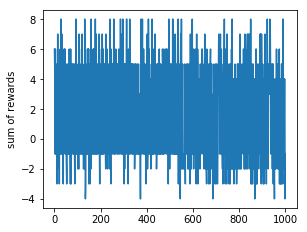

In [75]:
plot_poker_train(rtrace)

### Assumptions:
1. Here when we plot the rewards,obtained, they seem to be very random. May be the learning rate is very low. Lets check with a higher learning rate.

### When gamma=0.99, alpha=0.5, epsilon=0.5

In [77]:
agentPoker = RLAgentPoker()

rtrace = agentPoker.train(gamma=0.99, alpha=0.5, epsilon=0.5, maxiter=1000)

C:\Users\megha\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:110: RuntimeWarning: invalid value encountered in double_scalars


In [78]:
def plot_poker_train(rtrace):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(221)
    # TODO: plot rewards 
    plt.plot(rtrace)
    plt.ylabel("sum of rewards")

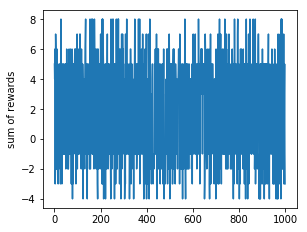

In [79]:
plot_poker_train(rtrace)

### Assumptions:
1. When the learning rate is high,there are higher chances of getting a negative rewards. Let try to explore number of states by decreasing the epsilon value to 0.1, so that it can choose random action values.

### When gamma=0.99, alpha=0.5, epsilon=0.1

In [83]:
agentPoker = RLAgentPoker()

rtrace = agentPoker.train(gamma=0.99, alpha=0.5, epsilon=0.1, maxiter=1000)

C:\Users\megha\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:110: RuntimeWarning: invalid value encountered in double_scalars


In [84]:
def plot_poker_train(rtrace):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(221)
    # TODO: plot rewards 
    plt.plot(rtrace)
    plt.ylabel("sum of rewards")

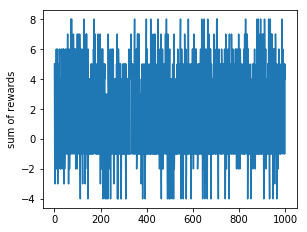

In [85]:
plot_poker_train(rtrace)

### Assumptions:
1. Now we can see that there are quite a less number of negative rewards. I think these parameters are okay for the poker agent to play well

In [53]:
pokerenv = Poker(number_of_player=2)
player1 = Player("Meghana", start_balance = 10, is_computer =  0)
computer1 = Player("computer1", start_balance = 10, is_computer = 1)

pokerenv.add_player(player1)
pokerenv.add_player(computer1)

reward = agentPoker.test(pokerenv)
print("The reward for the player is ",reward)

--------------------------------------------------
Deal Start!
Start State: {'other_stats': [[9, 1]], 'total_pot_balance': 2, 'player_stats': [12, 9, 1]}
action:  3
Final Result: ({'other_stats': [[9, 1]], 'total_pot_balance': 5, 'player_stats': [12, 11, 4]}, 5, True)
**************************************************
--------------------------------------------------
Deal Start!
Start State: {'other_stats': [[8, 1]], 'total_pot_balance': 2, 'player_stats': [2, 10, 1]}
action:  3
Final Result: ({'other_stats': [[8, 1]], 'total_pot_balance': 5, 'player_stats': [2, 12, 4]}, 5, True)
**************************************************
--------------------------------------------------
Deal Start!
Start State: {'other_stats': [[7, 1]], 'total_pot_balance': 2, 'player_stats': [1, 11, 1]}
action:  1
action  1
Final Result: ({'other_stats': [[11.0, 4]], 'total_pot_balance': 7, 'player_stats': [1, 9, 3]}, -3, True)
**************************************************
-----------------------------

### Selected Parameters:

gamma=0.99

alpha=0.5

epsilon=0.1

# V. Conclusions

1. Choosing the type of RL algorithm was quite confusing. Later I went with SARSA, because QLearning assumes that it has optimum policy which is not. I am still researching to know in which cases we can prefer QLearning over SARSA.
2. FOr the maze problem and poker, choosing the right parameter was difficult. I had to run lot of analysis and generate plots to get tot know the right parameters(gamma,alpha,epsilon)
3. For the maze problem, one of the trace did not reach the goal. It took me some time to understand the reason behind it was because the grid was not explored.

# Extra Credit

- Let us have Poker Tournament in class (Nov 6th.)!
- Top 4 (or more) students will get an extra credit. 
- 2 (or more?) unique training attemps will also get an extra credit. (Sales for it to be considered.) 

## Grading

We will test your notebook with an additional grid.txt file. Please make sure to test in different maze input files. 

points | | description
--|--|:--
5 | Overview| states the objective and the appraoch 
10 | Maze Problem | 
 | 5| Includes description of maze problem
 | 5| Explains the GridWorld
10 | Poker 
 | 5| Includes description of poker problem
 | 5| Explains the Poker
25 | Methods | 
 | 5| Review of the SARSA and Q-Learning
 | 5| Choice of TD learning and Reason
 |10| Implementation of the selected approach
 | 5| explanation of the codes
45 | Results 
| 5| Reports the selected parameters for both problems. 
|20| Experimental outputs that show the choice of parameters. How do you choose them? (10 points per each problem)
|10| Output plots (5 for each)
|10| reading and analysis of learning results and plots (5 for each)
5 | Conclusions 
